# Adversarial Examples

### Introduction

本章研究一个愚弄神经网络的方法，非常简单的在原始输入图片上加入一些噪点，得就可以让一个 state-of-the-art 的神经网络错误得将输入图片分类为我们指定的任意分类结果；这个方法只能欺骗神经网络，而不能欺骗人

### Flowchart

我们将继续使用 Inception model， 流程如下：

将原始图片加上噪点图片合成，并输入 Inception model，目标是找到对应的噪点图片能够导致模型错误的分类为我们指定的类型，在这里我们选定的类型为 'bookcase' (class-number 300).

我们还会引入一个新的损失函数, 计算 cross-entropy 来度量 Inception model 对噪点图片的分类结果；于是我们通过损失函数对噪点图片的 gradient，就可以迭代的更新噪点图片，得到最终的噪点图片了。换句话说，在 backprop 的过程中，我们保持 Inception model 中的 weights 不变，而是更新噪点图片的值，使噪点图片的像素按减少损失函数结果的方向，也就是说向着把输入图片分类为 bookcase 的方向调整

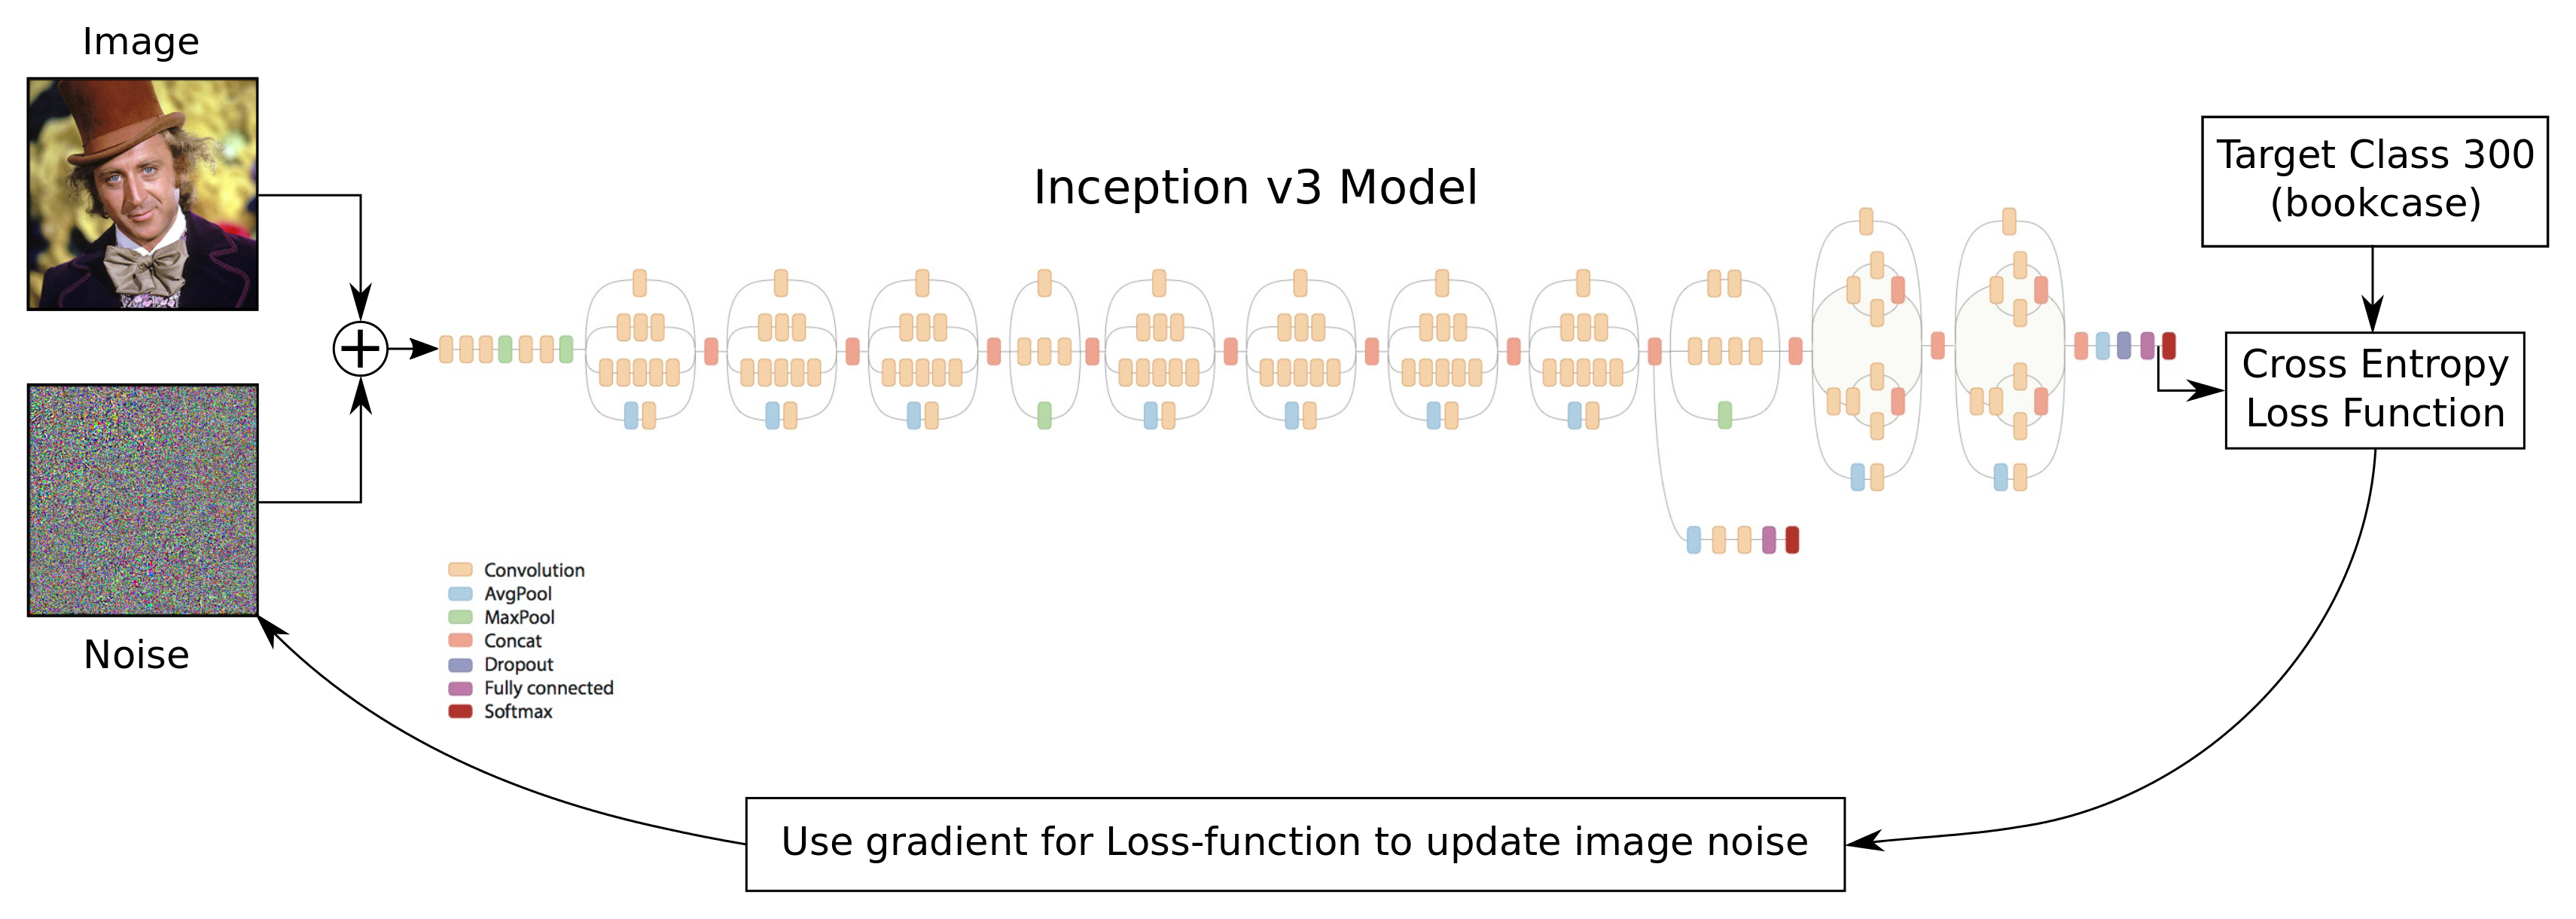

In [1]:
from IPython.display import Image, display
Image('images/11_adversarial_examples_flowchart.png')

### Imports

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os

import inception

In [3]:
tf.__version__

'0.9.0'

### Inception Model

In [4]:
# inception.data_dir = 'inception/'
inception.maybe_download()

Data has apparently already been downloaded and unpacked.


In [5]:
model = inception.Inception()

##### Inception Model 的输入和输出

Inception 模型的输入图片为 299 x 299，输入图片需要首先被 resize；下面的语句获取 graph 中 resize 之后的可以用做输入的图片

In [6]:
resized_image = model.resized_image

输出为 y_pred 以及之前得到的未经过 scale 的 softmax 输出 y_logits

In [7]:
y_pred = model.y_pred

In [8]:
y_logits = model.y_logits

##### 对 Inception Model 做一些 Hack

前面说过，我们需要一个新的 loss-function 用于通过 gradient 调整输入图片；这里并没有修改原有的 Incepition model weights 和结构，只是新增了 loss 和 gradient 变量的计算

In [31]:
with model.graph.as_default():    # 设置 Inception model 为 default graph，这样后续的修改都针对这个 graph
    # 目标分类 'bookcase'，其值为 300
    pl_cls_target = tf.placeholder(dtype=tf.int32)
    # 设置 Loss func，并传入目标分类值
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=y_logits, labels=[pl_cls_target])
    # 设置 gradient，这个函数非常重要，也非常之强大啊；相当于说在原来的 Inception model 的 graph 中加入了一个 loss 和 gradient 的计算
    gradient = tf.gradients(loss, resized_image)

### TensorFlow Run

In [10]:
session = tf.Session(graph=model.graph)

##### 实现 Adversary Noise 的逻辑

噪点初始化为 0，然后迭代的通过 gradient 更新，直到 Inception 对输入的预测分类为 bookcase 的几率超过 99% 或者达到最大次数限制为止

In [52]:
def find_adversary_noise(image_path, cls_target, noise_limit=3.0,    # 原始图片、希望预测的分类结果、noise 的极限(希望不要太大)
                         required_score=0.99, max_iterations=100):   # 停止阈值、最大迭代次数
    # 把原始图片 feed 入模型
    feed_dict = model._create_feed_dict(image_path=image_path)
    # run 出 resize 之后的输入图片以及预测结果
    pred, image = session.run([y_pred, resized_image], feed_dict=feed_dict)

    # 原来 pred 为 二维，batchsize x num_class，这里只传一张图，故此 batchsize 为一，故此是 1 X num_class [[p1, p2 ...]]
    #  转为一维 [p1, p2 ...]，然后看一下原始图片的分类情况  
    pred = np.squeeze(pred)
    # 得到分类的 cls
    cls_source = np.argmax(pred)
    # 得到所预测分类的 score (或者说 Probability)
    score_source_org = pred.max()
    # 获取预测分类和希望预测分类结果的名字
    name_source = model.name_lookup.cls_to_name(cls_source, only_first_name=True)
    name_target = model.name_lookup.cls_to_name(cls_target, only_first_name=True)

    # 初始化 noise
    noise = 0
    # 下面开始迭代更新 noise
    for i in range(max_iterations):
        print("Iteration:", i)

        # 把 noise 合成到原始图片中，这里 images 是经过 resize 之后的图片
        noisy_image = image + noise
        # 让像素仍然在 0~255 之间，这是 Inception 模型的要求
        noisy_image = np.clip(a=noisy_image, a_min=0.0, a_max=255.0)

        # 把处理后的图片 feed in。同时还带上目标预测分类，这是因为 Loss 和 gradient 需要目标预测分类值
        feed_dict = {model.tensor_name_resized_image: noisy_image, pl_cls_target: cls_target}
        # 计算预测结果和 gradient
        # pred, grad = session.run([y_pred, gradient], feed_dict=feed_dict) 不知道为啥这个不灵
        pred = session.run(y_pred, feed_dict=feed_dict)
        grad = session.run(gradient, feed_dict=feed_dict)

        pred = np.squeeze(pred)
        # 查看预测分类和目标分类上各自的得分，并打印
        score_source = pred[cls_source]
        score_target = pred[cls_target]
        msg = "Source score: {0:>7.2%}, class-number: {1:>4}, class-name: {2}"
        print(msg.format(score_source, cls_source, name_source))
        msg = "Target score: {0:>7.2%}, class-number: {1:>4}, class-name: {2}"
        print(msg.format(score_target, cls_target, name_target))

        # 一维化 grad
        grad = np.array(grad).squeeze()
        
        # 防止 grad 过小
        grad_absmax = np.abs(grad).max()
        if grad_absmax < 1e-10:
            grad_absmax = 1e-10

        # 像素的范围 0~255。这里让 grad 变化最大的位置更新步长为 7
        step_size = 7 / grad_absmax
        # 打印 gradient 的信息
        msg = "Gradient min: {0:>9.6f}, max: {1:>9.6f}, stepsize: {2:>9.2f}"
        print(msg.format(grad.min(), grad.max(), step_size))

        # Newline.
        print()

        # 如果对目标分类的预测没有达到目标
        if score_target < required_score:
            # 那么更新噪点
            noise -= step_size * grad
            # 防止噪点超限
            noise = np.clip(a=noise, a_min=-noise_limit, a_max=noise_limit)
        else:
            # 否则，已经 OK 了！
            break

    return image.squeeze(), noisy_image.squeeze(), noise, \
           name_source, name_target, \
           score_source, score_source_org, score_target

##### 辅助函数来绘制图片

为了绘制 noise，需要把像素调整到 0~1

In [12]:
def normalize_image(x):
    x_min = x.min()
    x_max = x.max()
    x_norm = (x - x_min) / (x_max - x_min)
    return x_norm

绘制图片

In [13]:
def plot_images(image, noise, noisy_image,        # 参数和上面得到 noise 部分的输出类似
                name_source, name_target,
                score_source, score_source_org, score_target):
    fig, axes = plt.subplots(1, 3, figsize=(10,10))
    fig.subplots_adjust(hspace=0.1, wspace=0.1)

    smooth = True
    if smooth:
        interpolation = 'spline16'
    else:
        interpolation = 'nearest'

    ax = axes.flat[0]
    ax.imshow(image / 255.0, interpolation=interpolation)    # 0~255 --> 0~1
    msg = "Original Image:\n{0} ({1:.2%})"
    xlabel = msg.format(name_source, score_source_org)
    ax.set_xlabel(xlabel)

    ax = axes.flat[1]
    ax.imshow(noisy_image / 255.0, interpolation=interpolation)
    msg = "Image + Noise:\n{0} ({1:.2%})\n{2} ({3:.2%})"
    xlabel = msg.format(name_source, score_source, name_target, score_target)
    ax.set_xlabel(xlabel)

    ax = axes.flat[2]
    ax.imshow(normalize_image(noise), interpolation=interpolation)
    xlabel = "Amplified Noise"
    ax.set_xlabel(xlabel)

    for ax in axes.flat:
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

##### 全流程整合如下

In [14]:
def adversary_example(image_path, cls_target, noise_limit, required_score):
    image, noisy_image, noise, \
    name_source, name_target, \
    score_source, score_source_org, score_target = \
        find_adversary_noise(image_path=image_path,
                             cls_target=cls_target,
                             noise_limit=noise_limit,
                             required_score=required_score)

    plot_images(image=image, noise=noise, noisy_image=noisy_image,
                name_source=name_source, name_target=name_target,
                score_source=score_source,
                score_source_org=score_source_org,
                score_target=score_target)

    msg = "Noise min: {0:.3f}, max: {1:.3f}, mean: {2:.3f}, std: {3:.3f}"
    print(msg.format(noise.min(), noise.max(), noise.mean(), noise.std()))

### 结果展示

##### 1. 鹦鹉

('Iteration:', 0)
Source score:  97.30%, class-number:  409, class-name: macaw
Target score:   0.00%, class-number:  300, class-name: bookcase
Gradient min: -0.002134, max:  0.002331, stepsize:   3003.62
()
('Iteration:', 1)
Source score:  83.22%, class-number:  409, class-name: macaw
Target score:   0.03%, class-number:  300, class-name: bookcase
Gradient min: -0.001857, max:  0.001805, stepsize:   3769.77
()
('Iteration:', 2)
Source score:  45.03%, class-number:  409, class-name: macaw
Target score:   0.23%, class-number:  300, class-name: bookcase
Gradient min: -0.000831, max:  0.001106, stepsize:   6329.59
()
('Iteration:', 3)
Source score:  12.87%, class-number:  409, class-name: macaw
Target score:   1.05%, class-number:  300, class-name: bookcase
Gradient min: -0.000721, max:  0.000981, stepsize:   7136.07
()
('Iteration:', 4)
Source score:   0.71%, class-number:  409, class-name: macaw
Target score:   1.13%, class-number:  300, class-name: bookcase
Gradient min: -0.001549, max:

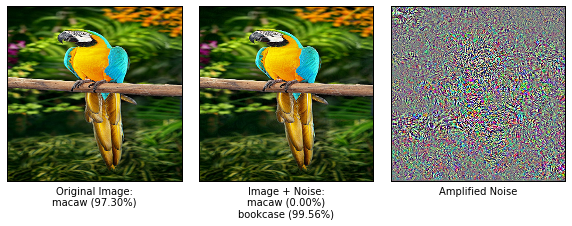

Noise min: -3.000, max: 3.000, mean: 0.001, std: 1.275


In [53]:
image_path = "images/parrot.jpg"

adversary_example(image_path=image_path, cls_target=300, noise_limit=3.0, required_score=0.99)

看到，随着迭代，原分类的概率越来越低，而目标分类概率越来越高；只用了 15 次迭代，noisy_image 就被识别为 book_case，而我们看上去仍然是鹦鹉啊

另一方面，看到最后的 noise 的 mean 只有 0.001，非常之小；但是相对 mean 来说，std 则大了很多，说明分布非常的不均匀

##### 2. Elon Musk

('Iteration:', 0)
Source score:  19.73%, class-number:  837, class-name: sweatshirt
Target score:   0.01%, class-number:  300, class-name: bookcase
Gradient min: -0.008348, max:  0.005946, stepsize:    838.49
()
('Iteration:', 1)
Source score:   1.77%, class-number:  837, class-name: sweatshirt
Target score:   0.24%, class-number:  300, class-name: bookcase
Gradient min: -0.002953, max:  0.005916, stepsize:   1183.27
()
('Iteration:', 2)
Source score:   0.53%, class-number:  837, class-name: sweatshirt
Target score:  10.11%, class-number:  300, class-name: bookcase
Gradient min: -0.006459, max:  0.006490, stepsize:   1078.65
()
('Iteration:', 3)
Source score:   0.24%, class-number:  837, class-name: sweatshirt
Target score:  67.11%, class-number:  300, class-name: bookcase
Gradient min: -0.001443, max:  0.002054, stepsize:   3408.48
()
('Iteration:', 4)
Source score:   0.01%, class-number:  837, class-name: sweatshirt
Target score:  83.66%, class-number:  300, class-name: bookcase
Grad

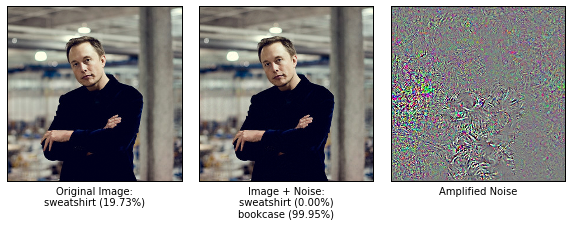

Noise min: -3.000, max: 3.000, mean: -0.001, std: 0.800


In [54]:
image_path = "images/elon_musk.jpg"

adversary_example(image_path=image_path,
                  cls_target=300,
                  noise_limit=3.0,
                  required_score=0.99)

##### 3. Willy Wonka (New)

('Iteration:', 0)
Source score:  31.48%, class-number:  535, class-name: sunglasses
Target score:   0.03%, class-number:  300, class-name: bookcase
Gradient min: -0.002181, max:  0.001478, stepsize:   3210.13
()
('Iteration:', 1)
Source score:   2.08%, class-number:  535, class-name: sunglasses
Target score:   0.13%, class-number:  300, class-name: bookcase
Gradient min: -0.001447, max:  0.001573, stepsize:   4450.27
()
('Iteration:', 2)
Source score:   6.37%, class-number:  535, class-name: sunglasses
Target score:   0.35%, class-number:  300, class-name: bookcase
Gradient min: -0.001409, max:  0.001635, stepsize:   4280.21
()
('Iteration:', 3)
Source score:   2.31%, class-number:  535, class-name: sunglasses
Target score:   1.02%, class-number:  300, class-name: bookcase
Gradient min: -0.001110, max:  0.001567, stepsize:   4466.09
()
('Iteration:', 4)
Source score:  12.14%, class-number:  535, class-name: sunglasses
Target score:   1.17%, class-number:  300, class-name: bookcase
Grad

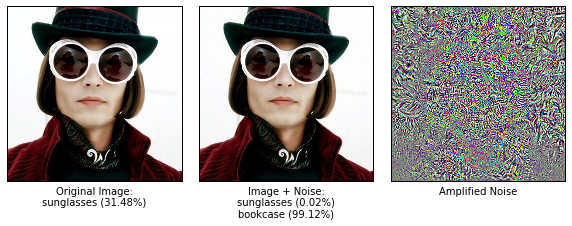

Noise min: -3.000, max: 3.000, mean: 0.007, std: 1.477


In [55]:
image_path = "images/willy_wonka_new.jpg"

adversary_example(image_path=image_path,
                  cls_target=300,
                  noise_limit=3.0,
                  required_score=0.99)

### Close TensorFlow Session

In [56]:
session.close()
model.close()